In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('cs-training.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [7]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Observations:
- Very unbalanced classes - will need to address this in modeling process.
- Large variance in DebtRatio and MonthlyIncome. 
- Also larger scale compared to other attributes - may need to consider scaling but RF should be robust to this.

In [8]:
# Limiting to 100K to save remaining 50K for ongoing model testing
df1 = df[:100000]

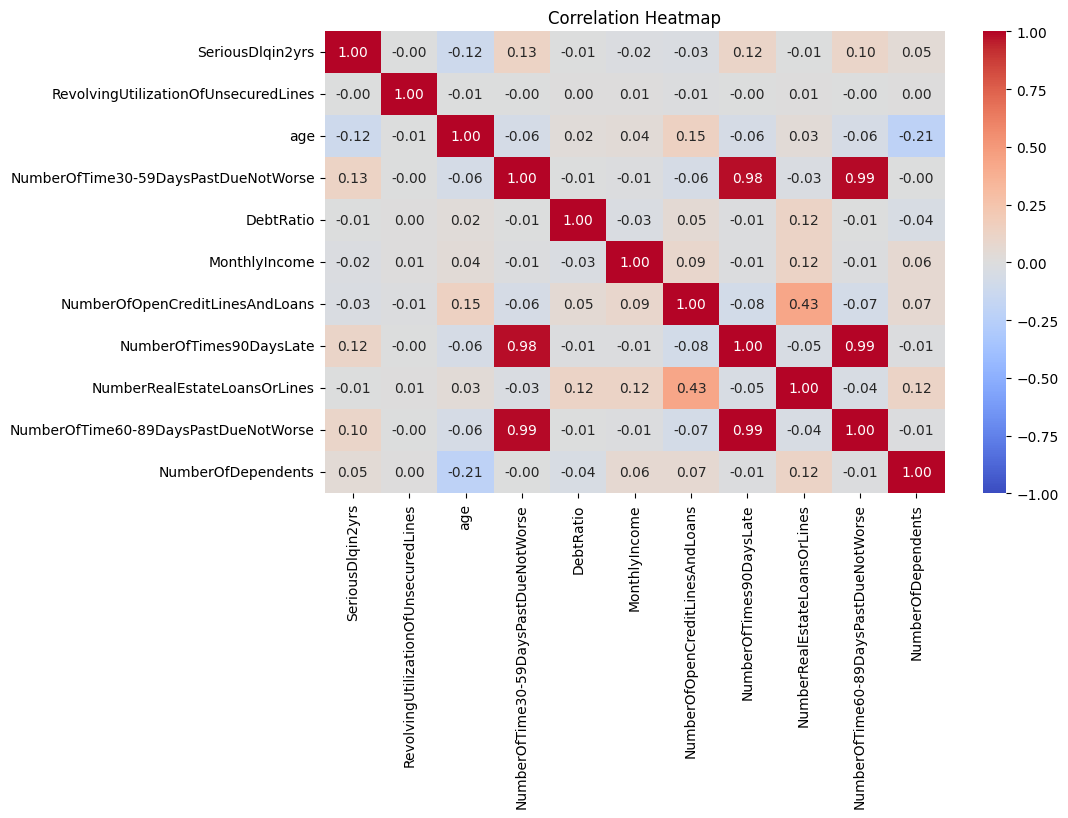

In [9]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

Strong correlation between `NumberOfTime30-59DaysPastDueNotWorse`,`NumberOfTime60-89DaysPastDueNotWorse` and `NumberofTimes90DaysLate`. Can drop 2 of these from analysis.

In [10]:
X = df1.drop(columns=['SeriousDlqin2yrs','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse'])
y = df1['SeriousDlqin2yrs']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                              y,
                                              test_size=.25, 
                                              random_state=12)

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [42]:
# Preprocessing for numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline for numerical features (impute missing with the mean)
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Impute missing values with the mean
])


# Combine both pipelines into a single column transformer
# (dropped scaling but may re integrate later)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features)
    ])

# Create the Random Forest pipeline
# Used class_weight='balanced' to account for the class imbalance. 
# This will give more weight to the minority class (delinquent). 
# This helps to improve recall (i.e., identifying more delinquent cases) but at the cost of precision (increased false positives).
model_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_pipeline),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42,class_weight='balanced'))
])

In [43]:
# Define the hyperparameters to search
param_grid = {
    'classifier__n_estimators': [100, 125],  # Number of trees
    'classifier__max_depth': [10, 15],  # Maximum depth of the trees
    # 'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    # 'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    # 'classifier__class_weight': ['balanced', None]  # Class weighting for imbalance handling
}

# Initialize GridSearchCV with the pipeline and hyperparameters
# Given the domain of financial distress prediction, higher recall is preferred to avoid 
# missing delinquent cases that could result in financial losses.
grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='recall')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Classification Report for Best Model:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix for Best Model:\n", confusion_matrix(y_test, y_pred_best))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 125}
Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.97      0.81      0.89     23336
           1       0.21      0.68      0.32      1664

    accuracy                           0.80     25000
   macro avg       0.59      0.75      0.60     25000
weighted avg       0.92      0.80      0.85     25000

Confusion Matrix for Best Model:
 [[18969  4367]
 [  529  1135]]


In [44]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_pipeline),
    ('classifier', RandomForestClassifier(n_estimators=125, max_depth=10, random_state=42,class_weight='balanced'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (delinquent)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Test cross-validation to assess the performance across multiple splits
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

AUC: 0.8269
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.89     23336
           1       0.21      0.68      0.32      1664

    accuracy                           0.80     25000
   macro avg       0.59      0.75      0.60     25000
weighted avg       0.92      0.80      0.85     25000

Confusion Matrix:
 [[18969  4367]
 [  529  1135]]
Cross-validation accuracy: 0.8025 ± 0.0029


In [45]:
# Perform cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='roc_auc')
print(f"Cross-validation AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation AUC: 0.8294 ± 0.0014


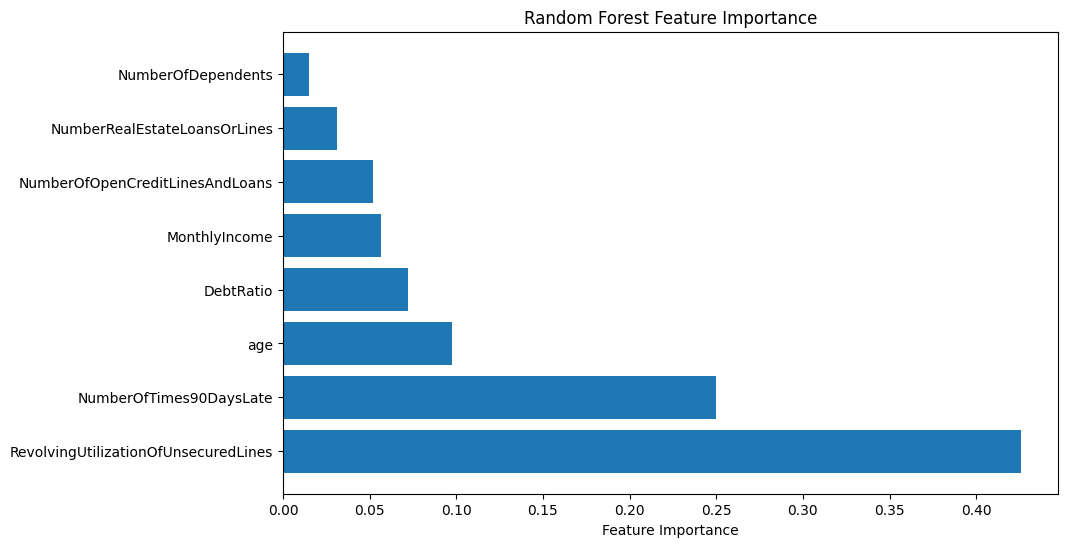

In [46]:
# Get feature importance from the trained Random Forest model
feature_importances = model_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Get the feature names
features = X.columns

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

Now going to explore possible interactions between features to improve the model. Partial dependence plots can help identify feature interactions by showing how a feature affects the predicted outcome while controlling for the influence of other features:

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [56]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

In [ ]:
# X_train['group_90days_late'] = np.where(X_train['NumberOfTimes90DaysLate'] == 0, '0', X_train['NumberOfTimes90DaysLate'])
# X_train['group_90days_late'] = np.where((X_train['NumberOfTimes90DaysLate'] >= 1) & (X_train['NumberOfTimes90DaysLate'] <= 4), '1-4', '5+')

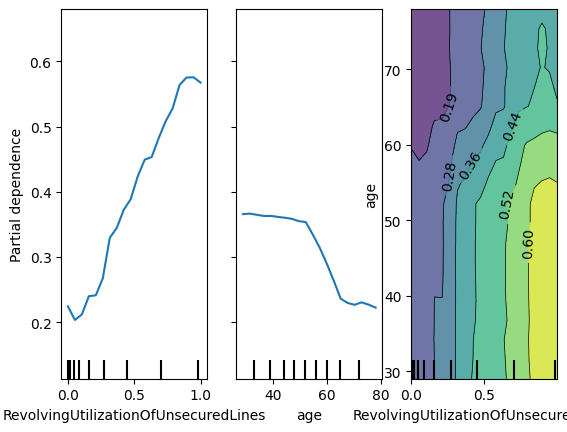

In [57]:
# Get partial dependence data 
top_features = [X.columns[i] for i in indices[:3]]
pdp_results = PartialDependenceDisplay.from_estimator(best_model,
                                       X_train,
                                       features=['RevolvingUtilizationOfUnsecuredLines','age', ('RevolvingUtilizationOfUnsecuredLines','age')],
                                       kind='average',
                                       **common_params
                                       )



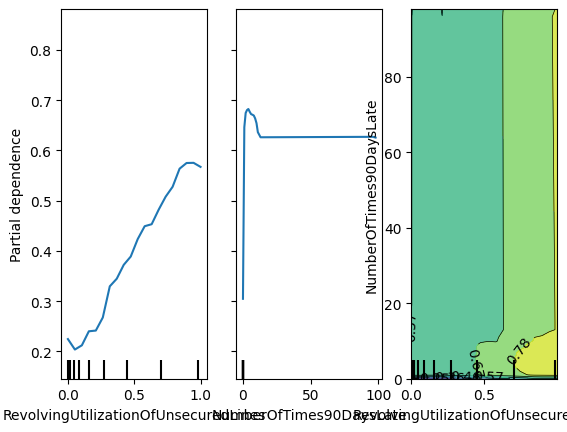

In [71]:
# Get partial dependence data 
top_features = [X.columns[i] for i in indices[:3]]
pdp_results = PartialDependenceDisplay.from_estimator(best_model,
                                       X_train,
                                       features=['RevolvingUtilizationOfUnsecuredLines','NumberOfTimes90DaysLate', ('RevolvingUtilizationOfUnsecuredLines','NumberOfTimes90DaysLate')],
                                       kind='average',
                                       **common_params
                                       )

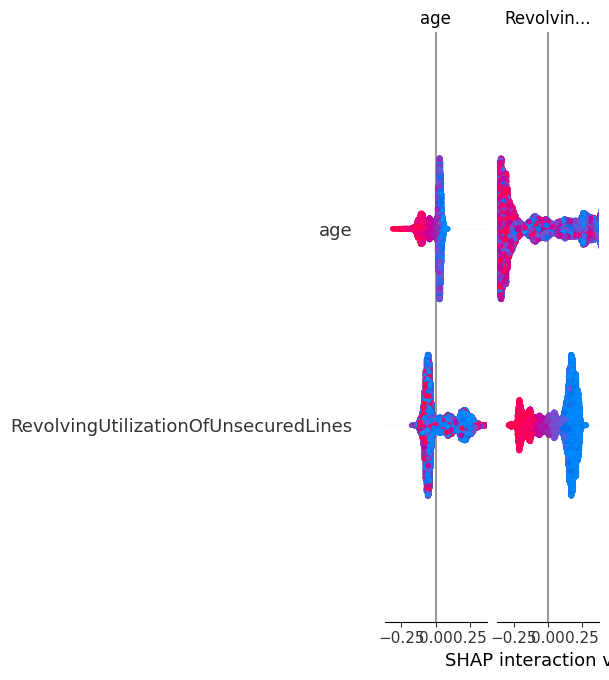

In [64]:
import shap

# Fit the model and explain it with SHAP
explainer = shap.TreeExplainer(model_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot to understand feature interactions
shap.summary_plot(shap_values, X_test)


In [30]:
# Retrain on the full dataset
model_pipeline.fit(X, y)  # Use the entire dataset (X and y)


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer())])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=0,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [31]:
X_holdout = df.iloc[100001:105000].drop(columns=['SeriousDlqin2yrs','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse'])
y_holdout = df.iloc[100001:105000]['SeriousDlqin2yrs']

In [32]:
# Predict on the test set
y_pred_holdout = model_pipeline.predict(X_holdout)
y_prob_holdout = model_pipeline.predict_proba(X_holdout)[:, 1]  # Get probabilities for the positive class (delinquent)

# Calculate the AUC
auc = roc_auc_score(y_holdout, y_prob_holdout)
print(f"AUC: {auc:.4f}")

# Evaluate the model
print("Classification Report:\n", classification_report(y_holdout, y_pred_holdout))
print("Confusion Matrix:\n", confusion_matrix(y_holdout, y_pred_holdout))

AUC: 0.8097
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      4659
           1       0.27      0.53      0.36       340

    accuracy                           0.87      4999
   macro avg       0.62      0.71      0.64      4999
weighted avg       0.92      0.87      0.89      4999

Confusion Matrix:
 [[4171  488]
 [ 160  180]]


In [37]:
# # Define the hyperparameters to search
# param_grid = {
#     'classifier__n_estimators': [100, 125],  # Number of trees
#     'classifier__max_depth': [10, 20],  # Maximum depth of the trees
#     'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
#     'classifier__class_weight': ['balanced', None]  # Class weighting for imbalance handling
# }

# # Initialize GridSearchCV with the pipeline and hyperparameters
# grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters and best model
# print("Best Hyperparameters:", grid_search.best_params_)

# # Evaluate the best model on the test set
# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test)
# print("Classification Report for Best Model:\n", classification_report(y_test, y_pred_best))
# print("Confusion Matrix for Best Model:\n", confusion_matrix(y_test, y_pred_best))


Fitting 5 folds for each of 162 candidates, totalling 810 fits


/Users/tawneykirkland/Desktop/GiveMeSomeCredit/venv/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tawneykirkland/Desktop/GiveMeSomeCredit/venv/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tawneykirkland/Desktop/GiveMeSomeCredit/venv/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tawneykirkland/Desktop/GiveMeSomeCredit/venv/lib/python3.11/site-packages/s

Best Hyperparameters: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     35018
           1       0.59      0.16      0.26      2482

    accuracy                           0.94     37500
   macro avg       0.77      0.58      0.61     37500
weighted avg       0.92      0.94      0.92     37500

Confusion Matrix for Best Model:
 [[34737   281]
 [ 2078   404]]


# Now test XGBoost

In [ ]:
import xgboost as xgb

In [21]:
# Preprocessing for numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline for numerical features (impute missing with the mean)
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Impute missing values with the mean
])


# Combine both pipelines into a single column transformer
# (dropped scaling but may re integrate later)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features)
    ])

# Create the XGBoost pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_pipeline),
    ('classifier', xgb.XGBClassifier(objective="binary:logistic", random_state=42))
])


In [41]:
# Define the hyperparameters to search
param_grid = {
    'classifier__max_depth': [6, 8, 10],  # Maximum depth of the trees
    'classifier__max_delta_step': [2, 4, 6],  
    'classifier__scale_pos_weight': [5, 8, 10, 20], 
    'classifier__learning_rate': [0.01, 0.05],
    # 'classifier__n_estimators': [50, 100, 200],
    'classifier__subsample': [0.7, 0.8],
    'classifier__colsample_bytree': [0.7, 0.8],
    'classifier__min_child_weight': [1, 2]
}

# Initialize GridSearchCV with the pipeline and hyperparameters
# Given the domain of financial distress prediction, higher recall is preferred to avoid 
# missing delinquent cases that could result in financial losses.
grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='recall')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Classification Report for Best Model:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix for Best Model:\n", confusion_matrix(y_test, y_pred_best))

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best Hyperparameters: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.01, 'classifier__max_delta_step': 2, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__scale_pos_weight': 20, 'classifier__subsample': 0.8}
Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.98      0.61      0.76     23336
           1       0.14      0.85      0.23      1664

    accuracy                           0.63     25000
   macro avg       0.56      0.73      0.50     25000
weighted avg       0.93      0.63      0.72     25000

Confusion Matrix for Best Model:
 [[14341  8995]
 [  252  1412]]


In [28]:
# Create the XGBoost pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_pipeline),
    ('classifier', xgb.XGBClassifier(objective="binary:logistic",
                                     max_delta_step= 0,
                                     max_depth=6, 
                                     scale_pos_weight= 8,
                                     random_state=42))
])

In [29]:
# Train the model
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (delinquent)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Test cross-validation to assess the performance across multiple splits
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

AUC: 0.8113
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     23336
           1       0.27      0.53      0.36      1664

    accuracy                           0.87     25000
   macro avg       0.62      0.71      0.64     25000
weighted avg       0.92      0.87      0.89     25000

Confusion Matrix:
 [[20948  2388]
 [  780   884]]
Cross-validation accuracy: 0.8706 ± 0.0020


In [33]:
# Retrain on the full dataset
model_pipeline.fit(X, y)  # Use the entire dataset (X and y)


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer())])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=0,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [34]:
# Predict on the test set
y_pred_holdout = model_pipeline.predict(X_holdout)
y_prob_holdout = model_pipeline.predict_proba(X_holdout)[:, 1]  # Get probabilities for the positive class (delinquent)

# Calculate the AUC
auc = roc_auc_score(y_holdout, y_prob_holdout)
print(f"AUC: {auc:.4f}")

# Evaluate the model
print("Classification Report:\n", classification_report(y_holdout, y_pred_holdout))
print("Confusion Matrix:\n", confusion_matrix(y_holdout, y_pred_holdout))

AUC: 0.8097
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      4659
           1       0.27      0.53      0.36       340

    accuracy                           0.87      4999
   macro avg       0.62      0.71      0.64      4999
weighted avg       0.92      0.87      0.89      4999

Confusion Matrix:
 [[4171  488]
 [ 160  180]]
